<a href="https://colab.research.google.com/github/Kristytiki/Neural-Network/blob/master/Project_1_PCA,_Antuencoder_and_FLD_for_Analyzing_Human_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load dataset with 800 training image(800*128*128) and 200 testing image(200*128*128)
"""
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""
from google.colab import drive
drive.mount('/content/drive')


In [0]:
# read data
X_train = np.load("/content/drive/My Drive/Colab Notebooks/X_train.npy")
X_test = np.load("/content/drive/My Drive/Colab Notebooks/X_test.npy")

# 2.1.1
## 1. Display the first 10 eigen-faces

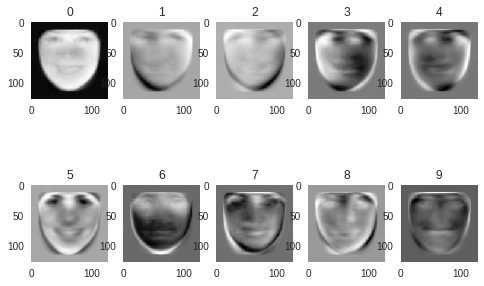

In [396]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X_train = X_train[:,:,:,2]
X_test = X_test[:,:,:,2]

n,p = X_train.shape[0:2]
k = 50
# get the mean faces
X = np.reshape(X_train,(n,-1))
m = np.mean(X, axis=0)
X_centered = X - np.mean(X, axis=0)
# use PCA to get eigenvector
pca = decomposition.PCA(n_components=k)
X_transformed = pca.fit_transform(X_centered)
pca.components_1 = np.reshape(pca.components_,(k,p,p))

# show image
#plt.imshow(pca.components_1[0,:,:])
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    im=ax.imshow(pca.components_1[i,:,:])
    ax.grid(False)
    plt.title(i)
#plt.savefig("imshow_4x4.png")



## 2. Plot 10 reconstruct faces and the corresponding original faces

In [0]:

p=128
T = 10
recons_10 = np.reshape(np.zeros(10*p*p),(10,p,p))
# choose first 10 image to reconstruct (use testing images) index = 10

n2 = 200
# faltten the matrix
X_test = np.reshape(X_test,(n2,-1))
X_test_centered = X_test - m
X_test_centered.shape

for j in range(10):
  b = np.reshape(np.zeros(T),(T,1))
  recons = np.reshape(np.zeros(p*p),(p,p))
  for i in range(T):
    b[i] = (np.reshape(X_test_centered[j,:],(p*p,1)).T).dot(np.reshape(pca.components_1[i,:,:],(p*p,1)))
    #print(b.shape)
    
    recons = np.reshape(np.multiply(np.reshape(pca.components_1[i,:,:],(p*p,1)),b[i]),(p,p)) + recons
    #print(recons)
  recons_10[j,:,:] = recons + np.reshape(np.mean(X_test, axis=0),(p,p))

"""
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    im=ax.imshow(recons_10[i,:,:])
    ax.grid(False)
    plt.title(i)
"""
# combine V channels with H.S
X_train = np.load("/content/drive/My Drive/Colab Notebooks/X_train.npy")
X_test = np.load("/content/drive/My Drive/Colab Notebooks/X_test.npy")
orginal_10 = X_test[0:10,:,:,:]
recon3_10 = np.reshape(np.zeros(10*p*p*3),(10,p,p,3))
for i in range(2):
  recon3_10[:,:,:,i] = orginal_10[:,:,:,i]
recon3_10[:,:,:,2] = recons_10[:,:,:]
from skimage.color import hsv2rgb
#orginal_10 = hsv2rgb(orginal_10)


In [402]:
!pip install imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import datetime
import imageio
def plot(samples,Nh,Nc,channel,IMG_HEIGHT, IMG_WIDTH):
    fig = plt.figure(figsize=(Nc, Nh))
    plt.clf()
    gs = gridspec.GridSpec(Nh, Nc)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[0:Nh*Nc,:,:,:]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if channel==1:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH)
            immin=(image[:,:]).min()
            immax=(image[:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image,cmap ='gray')
        else:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH,channel)
            immin=(image[:,:,:]).min()
            immax=(image[:,:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image)
    return 
  


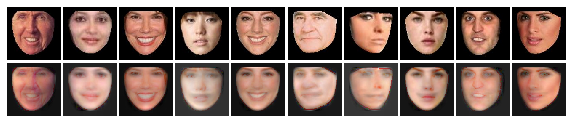

In [403]:
plot20 = np.reshape(np.zeros(20*p*p*3),(20,p,p,3))
"""
def scale_rgb(image):
    immin=(image[:,:,:]).min()
    immax=(image[:,:,:]).max()
    image=(image-immin)/(immax-immin+1e-8)
    return image
"""
for i in range(10):
    plot20[i,:,:,:] = hsv2rgb(orginal_10[i,:,:,:])
    plot20[10+i,:,:,:] = hsv2rgb(recon3_10[i,:,:,:])
    # rgb must in 0-1 range
    #plot20[10+i,:,:,:] = scale_rgb(plot20[10+i,:,:,:])
    
plot(plot20,2,10,3,128,128)

## 3. Plot the total reconstruction error per pixel over the number of eigen-faces K = 1,5,10,15,...,50

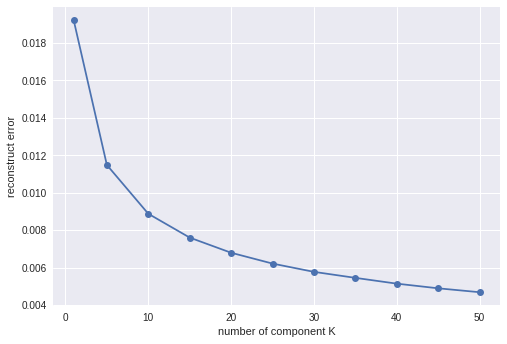

In [404]:
def recons(K,X_train,X_test):
    
    # get eigen-faces
    X_train = X_train[:,:,:,2]
    n,p = X_train.shape[0:2]
    X = np.reshape(X_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=K)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(K,p,p))
    
    
    # reconstruct test faces
    X_test = X_test[:,:,:,2]
    n2 = X_test.shape[0]
    recons_K = np.reshape(np.zeros(n2*p*p),(n2,p,p))
    X_test = np.reshape(X_test,(n2,-1))
    X_test_centered = X_test - np.mean(X, axis=0)
    X_test_centered.shape
    for j in range(n2):
        b = np.reshape(np.zeros(K),(K,1))
        recons = np.reshape(np.zeros(p*p),(p,p))
        for i in range(K):
            b[i] = (np.reshape(X_test_centered[j,:],(p*p,1)).T).dot(np.reshape(pca.components_1[i,:,:],(p*p,1)))
            #print(b.shape)
            recons = np.reshape(np.multiply(np.reshape(pca.components_1[i,:,:],(p*p,1)),b[i]),(p,p)) + recons
            
        #print(recons)
        recons_K[j,:,:] = recons + np.reshape(np.mean(X_test, axis=0),(p,p))
    return(pca.components_1,recons_K)


def total_re_error(K,X_train,X_test):

    n2 = X_test.shape[0]
    p = X_test.shape[1]

    # compare reconstruction error using HSV images
    orgin_img = X_test


    _,test_1 = recons(K,X_train,X_test)
    """
    test_img = np.reshape(np.zeros(n2*p*p*3),(n2,p,p,3))
    for i in range(2):
         test_img[:,:,:,i] = orgin_img[:,:,:,i]
    test_img[:,:,:,2] = test_1[:,:,:]
    for i in range(n2):
        orgin_img[i,:,:,:] = hsv2rgb(orgin_img[i,:,:,:])
        test_img[i,:,:,:] = hsv2rgb(test_img[i,:,:,:])
    """
    orgin_img = orgin_img[:,:,:,2]
    test_img = test_1[:,:,:]
    ## compute error
    a = 0
    for i in range(n2):
        a += np.sum((orgin_img[i,:,:]-test_img[i,:,:])**2)/(p*p)
    a = a/n2
    return(a)

K = np.array([1,5,10,15,20,25,30,35,40,45,50])
error_record = []
for k in K:
    error_record.append(total_re_error(k,X_train,X_test))

    error_record
plt.plot(K, error_record, '-o')
plt.xlabel("number of component K")
plt.ylabel("reconstruct error")
plt.show()

# 2.1.2 Landmarks
## 1. Display the first 10 eigen-warping and reconstruct the landmarks for the test faces.

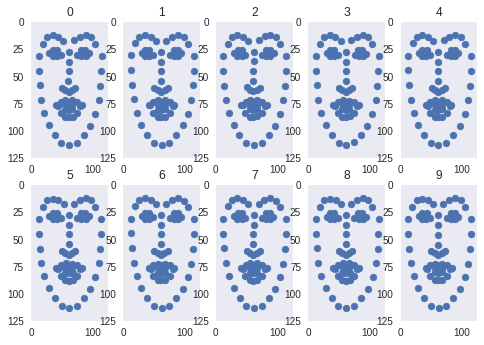

In [411]:
#upload mywarper.py and landmark.npy

import mywarper
mats = np.load('/content/drive/My Drive/Colab Notebooks/landmark.npy')
from sklearn.model_selection import train_test_split
m_train, m_test = train_test_split(mats,test_size=0.2)
m_train.shape
def m_recons(K,X_train,X_test):
    
    # get eigen-faces
    n,p,q = X_train.shape[0:3]
    X = np.reshape(X_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=K)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(K,p,q))
    
    
    # reconstruct test faces
    n2 = X_test.shape[0]
    recons_K = np.reshape(np.zeros(n2*p*q),(n2,p,q))
    X_test = np.reshape(X_test,(n2,-1))
    X_test_centered = X_test - np.mean(X, axis=0)
    X_test_centered.shape
    for j in range(n2):
        b = np.reshape(np.zeros(K),(K,1))
        recons = np.reshape(np.zeros(p*q),(p,q))
        for i in range(K):
            b[i] = (np.reshape(X_test_centered[j,:],(q*p,1)).T).dot(np.reshape(pca.components_1[i,:,:],(p*q,1)))
            #print(b.shape)
            recons = np.reshape(np.multiply(np.reshape(pca.components_1[i,:,:],(p*q,1)),b[i]),(p,q)) + recons
        #print(recons)
        recons_K[j,:,:] = recons + np.reshape(np.mean(X_test, axis=0),(p,q))

    return(np.mean(X, axis=0), pca.components_1,recons_K)

K = 50
mat_mean,pca10, remat = m_recons(50,m_train,m_test)
remat.shape
# 10-Eigen faces
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    tmpplot = pca10[i,:,:]+np.reshape(mat_mean,(68,2))
    #im=ax.scatter(tmpplot[:,0],1-tmpplot[:,1])
    im=ax.scatter(tmpplot[:,0],tmpplot[:,1])
    plt.xlim(0,125)
    plt.ylim(125,0)
    ax.grid(False)
    plt.title(i)
    

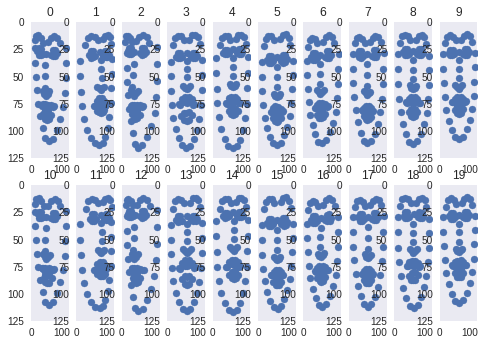

In [412]:
# reconstruct for testing landmarks
p,q = m_train.shape[1:3]

plot20 = np.reshape(np.zeros(20*p*q),(20,p,q))

for i in range(10):
    plot20[i,:,:] = m_test[i,:,:]
    plot20[10+i,:,:] = remat[i,:,:]
    

for i in range(20):
    ax= plt.subplot(2,10,i+1)
    tmpplot = plot20[i,:,:]
    #im=ax.scatter(tmpplot[:,0],1-tmpplot[:,1])
    im=ax.scatter(tmpplot[:,0],tmpplot[:,1])
    plt.xlim(0,125)
    plt.ylim(125,0)
    ax.grid(False)
    plt.title(i)

## 2. Plot the reconstruction error

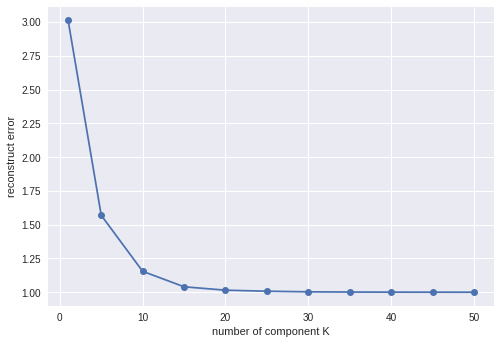

In [413]:
def m_total_re_error(K,X_train,X_test):

    n2,p,q = X_test.shape[0:3]
    
    # compare reconstruction error using HSV images
    


    _,_,test_1 = m_recons(K,X_train,X_test)
    """
    test_img = np.reshape(np.zeros(n2*p*p*3),(n2,p,p,3))
    for i in range(2):
         test_img[:,:,:,i] = orgin_img[:,:,:,i]
    test_img[:,:,:,2] = test_1[:,:,:]
    for i in range(n2):
        orgin_img[i,:,:,:] = hsv2rgb(orgin_img[i,:,:,:])
        test_img[i,:,:,:] = hsv2rgb(test_img[i,:,:,:])
    """
    orgin_img = X_test
    test_img = test_1[:,:,:]
    ## compute error
    a = 0
    for i in range(n2):
        a += np.sum(np.sqrt(np.sum((orgin_img[i,:,:]-test_img[i,:,:])**2,axis = 1)))/p
    a = a/n2
    return(a)

K = np.array([1,5,10,15,20,25,30,35,40,45,50])
error_record = []
for k in K:
    error_record.append(m_total_re_error(k,m_train,m_test))

    error_record
plt.plot(K, error_record, '-o')
plt.xlabel("number of component K")
plt.ylabel("reconstruct error")
plt.show()

# 2.1.3 Combine two steps


In [0]:
# For training set
# first align the images by warping their landmarks into the mean position
from mywarper import warp
images = np.load('/content/drive/My Drive/Colab Notebooks/image.npy')

img_train, img_test, m_train, m_test = train_test_split(images,mats,test_size=0.2)
img_train.shape
n,p1 = img_train.shape[0:2]
n,p2,q2 = m_train.shape[0:3]
n2 = img_test.shape[0]
np.reshape(m_train,(n,-1))

tc = np.mean(np.reshape(m_train,(n,-1)),axis = 0)
ali_img = []
for i in range(n):
    a = warp(img_train[i],m_train[i],np.reshape(tc,(p2,q2)))
    #print(a)
    ali_img.append(a)
ali_train = np.array(ali_img)
# compute the eigen-faces from the aligned images
def appear_fun(K,X_train):
    
    # get eigen-faces
    X_train = X_train[:,:,:,2]
    n,p = X_train.shape[0:2]
    X = np.reshape(X_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=K)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(K,p,p))
    return pca.components_1
#X_train = ali_train  
appear_ev = appear_fun(50,ali_train)
appear_ev.shape

# For testing part
# i) project its landmarks to the top 10 eigen-warpings, you get the reconstructed landmarks. 
# (here you lose a bit of geometric precision of reconstruction).
# remat (200*68*2)
_,_,remat = m_recons(10,m_train, m_test)
remat.shape
#ii) Warp the face image to the mean position and then project to the top k (say K=50) eigen-faces, 
#you get the reconstructed image at mean position (here you further lose a bit of appearance accuracy).
# recons_testali.shape 200*128*128

train_mean = np.reshape(np.mean(np.reshape(m_train,(n,-1)),axis = 0),(p2,q2))
img_train_mean = np.mean(np.reshape(img_train[:,:,:,2],(n,-1)),axis = 0)
test_ali = []
for i in range(n2):
    a = warp(img_test[i],m_test[i],train_mean)
    test_ali.append(a)
ali_test = np.array(test_ali)
ali_test1 = ali_test[:,:,:,2]
img_train_mean.shape

_,recons_testali = recons(50,ali_train,ali_test)
recons_testali = np.reshape(recons_testali,(n2,p1,p1,1))
# iii) Warp the reconstructed faces in step ii) to the positions reconstructed in step i). 
# recons_face 200*128*128*1
recons_face = []
for i in range(n2):
    a = warp(recons_testali[i],train_mean,remat[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(n2,p1,p1))

### Plot 20 reconstructed faces and their corresponding original faces. 

### Plot the reconstruction errors per pixel against the number of eigen-faces K = 1, 5, 10, 15, ..., 50.

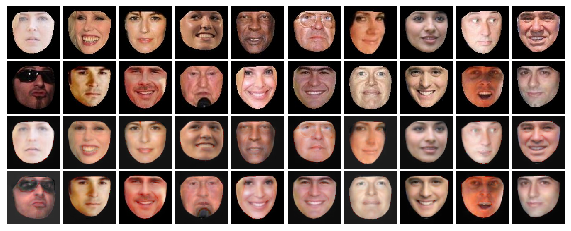

In [415]:
orginal_20 = img_test[0:20,:,:,:]
recon3_20 = np.reshape(np.zeros(20*p1*p1*3),(20,p1,p1,3))
for i in range(2):
  recon3_20[:,:,:,i] = orginal_20[:,:,:,i]
recon3_20[:,:,:,2] = recons_face[0:20,:,:]

plot20 = np.reshape(np.zeros(40*p1*p1*3),(40,p1,p1,3))
for i in range(20):
    plot20[i,:,:,:] = hsv2rgb(orginal_20[i,:,:,:])
    plot20[20+i,:,:,:] = hsv2rgb(recon3_20[i,:,:,:])
    # rgb must in 0-1 range
    #plot20[10+i,:,:,:] = scale_rgb(plot20[10+i,:,:,:])
    
plot(plot20,4,10,3,128,128)

1
5
10
15
20
25
30
35
40
45
50


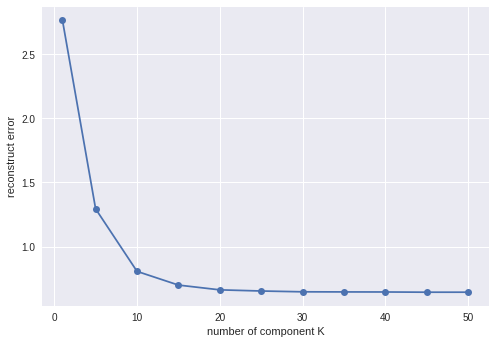

In [328]:
def re_error(img_train, img_test, m_train, m_test,K):
    n,p1 = img_train.shape[0:2]
    n,p2,q2 = m_train.shape[0:3]
    n2 = img_test.shape[0]
    # i)
    _,_,remat = m_recons(K,m_train, m_test)
    # ii)
    train_mean = np.reshape(np.mean(np.reshape(m_train,(n,-1)),axis = 0),(p2,q2))
    img_train_mean = np.mean(np.reshape(img_train[:,:,:,2],(n,-1)),axis = 0)
    test_ali = []
    for i in range(n2):
        a = warp(img_test[i],m_test[i],train_mean)
        test_ali.append(a)
    ali_test = np.array(test_ali)
    ali_test1 = ali_test[:,:,:,2]
    img_train_mean.shape

    _,recons_testali = recons(50,ali_train,ali_test)
    recons_testali = np.reshape(recons_testali,(n2,p1,p1,1))
    # iii)
    recons_face = []
    for i in range(n2):
        a = warp(recons_testali[i],train_mean,remat[i])
        recons_face.append(a)
    recons_face = np.array(recons_face)
    recons_face = np.reshape(recons_face,(n2,p1,p1))
    
    # compare reconstruction error using HSV images with V channel
    ## compute error
    a = 0
    for i in range(n2):
        a += np.sum((img_test[:,:,:,2]-recons_face[:,:,:])**2)/(p1*p1)
    a = a/n2
    return(a)

K = np.array([1,5,10,15,20,25,30,35,40,45,50])
error_record = []
for k in K:
    error_record.append(re_error(img_train, img_test, m_train, m_test,k))
    print(k)
    error_record
plt.plot(K, error_record, '-o')
plt.xlabel("number of component K")
plt.ylabel("reconstruct error")
plt.show()

# 2.1.4 Synthesize random faces


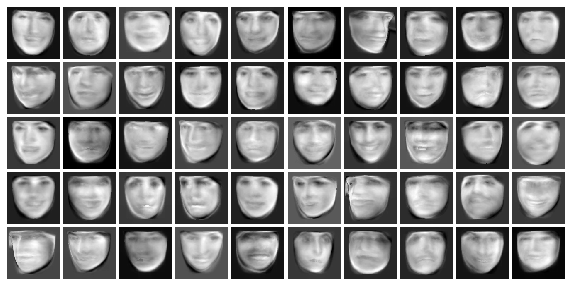

In [409]:
# randomly choose bi
#img_train, img_test, m_train, m_test
def random_bi(img_train, img_test, m_train, m_test,num,k1,k2):
    #num = 50
    #k1 = 50
    #k2 = 10
    n,p1 = img_train.shape[0:2]
    n,p2,q2 = m_train.shape[0:3]
    n2 = img_test.shape[0]


    X_train = img_train[:,:,:,0]
    X = np.reshape(X_train,(n,-1))
    m = np.mean(X, axis=0)
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=k1)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(k1,p1*p1))
    cov1 = np.diag(pca.explained_variance_)
    b1 = np.random.multivariate_normal(np.zeros(k1), cov1, num)
    I1 = np.reshape(np.zeros(num*p1*p1),(num,-1))
    for i in range(num):
        I1[i,:] = np.reshape(b1[i],(1,k1)).dot(pca.components_1) + np.mean(X, axis=0)
    I1 = np.reshape(I1,(num,p1,p1,1))

    X = np.reshape(m_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=k2)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_2 = np.reshape(pca.components_,(k2,p2*q2))
    cov2 = np.diag(pca.explained_variance_)
    b2 = np.random.multivariate_normal(np.zeros(k2), cov2, num)
    I2 = np.reshape(np.zeros(num*p2*q2),(num,-1))
    for i in range(num):
        I2[i,:] = np.reshape(b2[i],(1,k2)).dot(pca.components_2) + np.mean(X, axis=0)
    I2 = np.reshape(I2,(num,p2,q2))
    m = np.reshape(np.mean(X, axis=0),(p2,q2))
    return (m,I1,I2)
num = 50
k1 = 50
k2 = 10

m_landmark,I1,I2 = random_bi(img_train, img_test, m_train, m_test,num,k1,k2)
recons_face = []
for i in range(num):
    a = warp(I1[i],m_landmark,I2[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(num,p1,p1,1))

    
plot(recons_face,5,10,1,128,128)

# 2.2 Autoencoder: a non-linear method



In [3]:

!pip install torch
#!pip3 uninstall torchvision

    100% |████████████████████████████████| 519.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59374000 @  0x7f065f0e82a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [4]:
!pip3 install torchvision

    100% |████████████████████████████████| 61kB 2.5MB/s 
    100% |████████████████████████████████| 2.0MB 8.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [341]:
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt
import skimage
from skimage import io, transform
import scipy.io as sio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class args(object):
    def __init__(self):
        self.epochs = 50  # 300
        self.batch_size = 100
        self.seed = 12345
        self.device = 0
        self.image_dir = '/content/drive/My Drive/Colab Notebooks/data/images/'
        self.landmark_dir = '/content/drive/My Drive/Colab Notebooks/data/landmarks/'
        self.male_img_dir = '/content/drive/My Drive/Colab Notebooks/data/male_images/'
        self.female_img_dir = '/content/drive/My Drive/Colab Notebooks/data/female_images/'
        self.male_landmark = '/content/drive/My Drive/Colab Notebooks/data/male_landmarks/'
        self.female_landmark = '/content/drive/My Drive/Colab Notebooks/data/female_landmarks/'
        self.path = '/content/drive/My Drive/Colab Notebooks/data/model/'
        self.log = '/content/drive/My Drive/Colab Notebooks/data/log/'
        self.appear_lr = 7e-4
        self.landmark_lr = 1e-4
        self.cuda = None
        
args = args()
print(args.cuda)

None


In [0]:
##########################################
# Stat231 Project 1:
# Autoencoder
# Author: Zheqi Wu
##########################################

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class appearance_autoencoder(nn.Module):
    def __init__(self):
        super(appearance_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # TODO: Fill in the encoder structure
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )

        self.fc1 = nn.Sequential(                    
            # TODO: Fill in the FC layer structure
            nn.Linear(128*8*8, 50),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # TODO: Fill in the decoder structure
            # Hint: De-Conv in PyTorch: ConvTranspose2d 
            nn.ConvTranspose2d (50, 128, kernel_size=8, stride=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # TODO: Fill in forward pass
        x = self.encoder(x)
        z = self.fc1(x.view(-1,128*8*8))
        z = z.view(-1, 50, 1, 1)
        x_recon = self.decoder(z)
        return (z,x_recon)


class landmark_autoencoder(nn.Module):
    def __init__(self):
        super(landmark_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # TODO: Fill in the encoder structure
            nn.Linear(68*2, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 10),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            # TODO: Fill in the decoder structure
            nn.Linear(10, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 68*2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # TODO: Fill in forward pass

        z = self.encoder(x.view(-1,68*2)).cuda()
        x_recon = self.decoder(z).cuda()
        x_recon = x_recon.view(-1,68,2).cuda()
        return (z,x_recon)


class autoencoder(object):
    def __init__(self, appear_lr, landmark_lr, use_cuda):
        self.appear_model = appearance_autoencoder()
        self.landmark_model = landmark_autoencoder()
        self.use_cuda = use_cuda
        if use_cuda:
            self.appear_model.cuda()
            self.landmark_model.cuda()
        self.criterion = nn.MSELoss()
        self.appear_optim = optim.Adam(self.appear_model.parameters(), lr=appear_lr)
        self.landmark_optim = optim.Adam(self.landmark_model.parameters(), lr=landmark_lr)
        self.appear_testing_loss = 0
        self.landmark_testing_loss = 0
        self.proj_appear_train_list = [] # batch size=100
        self.proj_appear_test_list = [] #np.reshape(np.zeros(100*50),(100,50,1,1))
        self.proj_land_train_list = [] #np.reshape(np.zeros(100*10),(100,10))
        self.proj_land_test_list = [] #np.reshape(np.zeros(100*10),(100,10))
        
    def train_appear_model(self, epochs, trainloader):
        self.appear_model.train()
        epoch = 0
        # TODO: Train appearance autoencoder
        for epoch in range(0, epochs):
            training_loss = 0
            self.proj_appear_train_list = []
            for batch_idx, x in enumerate(trainloader):
                if self.use_cuda:
                    x = x.cuda()
                
                self.appear_optim.zero_grad()
                proj_appear_train, x_recon = self.appear_model(x)
                loss = self.criterion(x_recon, x)
                loss.backward()
                self.appear_optim.step()
                
                training_loss += loss.item()
                self.proj_appear_train_list.append((proj_appear_train.data).cpu().numpy())
            if (epoch%20==0):
                print('Image Training Epoch:{}, Loss:{:.6f}'.format(epoch, training_loss/len(trainloader)))
          

    def train_landmark_model(self, epochs, trainloader):
        self.landmark_model.train()
        epoch = 0
        # TODO: Train landmark autoencoder
        for epoch in range(0, epochs):
            training_loss = 0
            self.proj_land_train_list = []
            
            for batch_idx, x in enumerate(trainloader):
                if self.use_cuda:
                    x = x.cuda()
                
                self.landmark_optim.zero_grad()
                proj_land_train, x_recon = self.landmark_model(x)
                loss = self.criterion(x_recon, x)
                loss.backward()
                self.landmark_optim.step()
                
                training_loss += loss.item()
                self.proj_land_train_list.append((proj_land_train.data).cpu().numpy())
            if (epoch%20==0):
                print('Landmark Training Epoch:{}, Loss:{:.6f}'.format(epoch, training_loss/len(trainloader)))


    def test_appear_model(self, testloader):
        self.appear_model.eval()
        # TODO: Test appearance autoencoder
        x_recon_list = []
        for batch_idx, x in enumerate(testloader):
            if self.use_cuda:
                x = x.cuda()
            # forward + backward + optimize
            proj_appear_test,recon_x = self.appear_model(x)
            loss = self.criterion(recon_x, x)
            self.appear_testing_loss += loss.item() / len(testloader)
            x_recon_list.append((recon_x.data).cpu().numpy())
            self.proj_appear_test_list.append((proj_appear_test.data).cpu().numpy())
        print('Testing loss: %.6f' % (self.appear_testing_loss))
        return x_recon_list
        
    def test_landmark_model(self, testloader):
        self.landmark_model.eval()
        # TODO: Test landmark autoencoder
        x_recon_list = []
        for batch_idx, x in enumerate(testloader):
            if self.use_cuda:
                x = x.cuda()
            proj_land_test,recon_x = self.landmark_model(x)
            loss = self.criterion(recon_x, x)
            self.landmark_testing_loss += loss.item() / len(testloader)
            x_recon_list.append((recon_x.data).cpu().numpy())
            self.proj_land_test_list.append((proj_land_test.data).cpu().numpy())
        print('Testing loss: %.6f' % (self.landmark_testing_loss))
        return x_recon_list


### Please re-perform the experiments (3) in Section 2.1 by replacing PCA with auto-encoder. Specifically, the landmarks can be reconstructed and generated by the auto-encoder with fully-connected architecture, while the two-dimensional face images can be reconstructed and generated by the auto-encoder with convolutional architecture. It is worth to note that the extracted features or each dimension of the latent vector of the auto-encoder is not orthonormal as PCA.

Why the auto-encoder cannot apply into HSV images but only rgb images?

In [343]:
# Read Dataset (has been aligned)
from sklearn.model_selection import train_test_split
!pip install imageio
from mywarper import warp
"""
# original dataset
images = np.load('/content/drive/My Drive/Colab Notebooks/img_rgb.npy')
mats = np.load('/content/drive/My Drive/Colab Notebooks/landmark.npy')
images_list = []
mats_list =[]
split = 800
for i in range(images.shape[0]):
    images_list.append(images[i])
    mats_list.append(mats[i])
face_images_train = images_list[:split]
face_images_test = images_list[split:]
face_landmark_train = mats_list[:split]
face_landmark_test = mats_list[split:]

"""
images = np.load('/content/drive/My Drive/Colab Notebooks/img_rgb.npy')
mats = np.load('/content/drive/My Drive/Colab Notebooks/landmark.npy')

# aligned dataset
img_train, img_test, m_train, m_test = train_test_split(images,mats,test_size=0.2,random_state = 123)
#img_train.shape

def trans_list(X):
    list = []
    for i in range(X.shape[0]):
        list.append(X[i])
    return list

face_images_train = trans_list(ali_train)
face_images_test = trans_list(ali_test)
face_landmark_train = trans_list(m_train)
face_landmark_test = trans_list(m_test) 


Image Training Epoch:0, Loss:0.145903
Image Training Epoch:20, Loss:0.014807
Image Training Epoch:40, Loss:0.006851
Testing loss: 0.006383
Landmark Training Epoch:0, Loss:0.050645
Landmark Training Epoch:20, Loss:0.007834
Landmark Training Epoch:40, Loss:0.002832
Testing loss: 0.002456


0

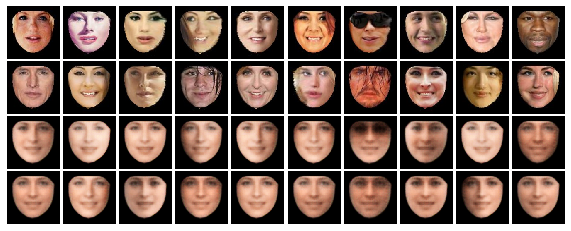

In [344]:
##########################################
# Stat231 Project 1:
# Autoencoder
# Author: Zheqi Wu
##########################################

# Construct Dataset
class ImgToTensor(object):
    def __call__(self, sample):
        sample = sample.transpose((2, 0, 1))
        return torch.tensor(sample, dtype=torch.float32)/255

class LandmarkToTensor(object):
    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float32)/128

class dataset_constructor(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample_data = self.dataset[idx]
        if self.transform:
            sample_data = self.transform(sample_data)
        return sample_data


def run_autoencoder(face_images_train,face_images_test,face_landmark_train,face_landmark_test):  #appear_lr, landmark_lr, epochs, use_cuda
    face_trainset = dataset_constructor(face_images_train, transform=transforms.Compose([
                                                                    ImgToTensor()]))
    face_testset = dataset_constructor(face_images_test, transform=transforms.Compose([
                                                                    ImgToTensor()]))
    face_trainloader = torch.utils.data.DataLoader(face_trainset, \
                                                    batch_size=args.batch_size, \
                                                    shuffle=True, \
                                                    num_workers=0)
    face_testloader = torch.utils.data.DataLoader(face_testset, \
                                                    batch_size=args.batch_size, \
                                                    shuffle=False, \
                                                    num_workers=0)

    landmark_trainset = dataset_constructor(face_landmark_train, transform=transforms.Compose([
                                                                    LandmarkToTensor()]))
    landmark_testset = dataset_constructor(face_landmark_test, transform=transforms.Compose([
                                                                    LandmarkToTensor()]))
    landmark_trainloader = torch.utils.data.DataLoader(landmark_trainset, \
                                                        batch_size=args.batch_size, \
                                                        shuffle=True, \
                                                        num_workers=0)
    landmark_testloader = torch.utils.data.DataLoader(landmark_testset, \
                                                        batch_size=args.batch_size, \
                                                        shuffle=False, \
                                                        num_workers=0)

    return (face_trainloader,face_testloader,landmark_trainloader,landmark_testloader)



args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
#torch.cuda.select_device(args.device)
#device = select_device(use_gpu=USE_GPU)

if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
face_trainloader,face_testloader,landmark_trainloader,landmark_testloader = run_autoencoder(face_images_train,face_images_test,face_landmark_train,face_landmark_test)
clf = autoencoder(args.appear_lr, args.landmark_lr, use_cuda = True)
clf.train_appear_model(args.epochs, face_trainloader)
x_recon_test_appear = clf.test_appear_model(face_testloader)
x_recon_test_appear = np.reshape(np.array(x_recon_test_appear),(200,3,128,128)).transpose(0,2,3,1) #.view(200,128,128,3)
clf.train_landmark_model(args.epochs, landmark_trainloader)
x_recon_test_land = clf.test_landmark_model(landmark_testloader)
x_recon_test_land = np.reshape(np.array(x_recon_test_land),(200,68,2)) #.view(200,128,128,3)
x_recon_test_land.shape


# warp back to their position
recons_face = []
train_mean = np.reshape(np.mean(np.reshape(m_train,(800,-1)),axis = 0),(68,2))
for i in range(200):
    a = warp(x_recon_test_appear[i],train_mean,x_recon_test_land[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(200,128,128,3))


x_new = (recons_face+1)*128
#x_new.shape

# plot
from mywarper import plot
from skimage.color import hsv2rgb

orginal_20 = np.array(face_images_test)[0:20,:,:,:]
#recon3_20 = recons_face[0:20,:,:,:]
recon3_20 = x_new[0:20,:,:,:]
p1 = 128

plot20 = np.reshape(np.zeros(40*p1*p1*3),(40,p1,p1,3))
for i in range(20):
    plot20[i,:,:,:] = orginal_20[i,:,:,:]
    plot20[20+i,:,:,:] = recon3_20[i,:,:,:]

# i) plot 20 orginial and reconstructed faces in the test set
plot(plot20,4,10,3,128,128)



In [0]:
# 2)plot the reconstructed error per pixel with k=1,5,...50
# TA said we can omit this part saving time

### 2. Interpolation: choose the first 4 dimensions of the latent variables of appearance that have the maximal variance, and show the interpolation results on each dimension while keeping the other dimensions fixed. Choose the first 2 dimensions of the latent variables of landmarks that have the maximal variance, and get the interpolation results on each dimension while keeping the other dimensions fixed. Show the results by warping a chosen face by the generated landmarks. Figure 3 shows an interpolation result for appearance and landmark respectively.

In [346]:
# find the 4/2 dimensions that have the maximal variance
# Given a image # get the random latent variables tag_record_img/tag_record_mat
tag = np.reshape(np.array(clf.proj_appear_test_list),(200,50))[0]
tag_0 = np.reshape(np.array(clf.proj_land_test_list),(200,10))[0]

proj_appear_train_list = np.reshape(np.array(clf.proj_appear_train_list),(800,50))

print(proj_appear_train_list.shape)
proj_land_train_list = np.reshape(np.array(clf.proj_land_train_list),(800,10))
print(proj_land_train_list.shape)
a = np.var(proj_appear_train_list,axis = 0)
a1 = a.argsort()[-4:][::-1]
b = np.var(proj_land_train_list,axis = 0)
b1 = b.argsort()[-2:][::-1]
tag_record_img = np.reshape(np.repeat(tag, 40),(50,40)).T
for j,ind in enumerate(a1):
    for i in range(10):
        tag_record_img[i+j*10,ind] = np.random.normal(tag[ind], np.sqrt(a[ind]), 1)
tag_record_mat = np.reshape(np.repeat(tag_0, 40),(10,40)).T
for j,ind in enumerate(b1):
    for i in range(10):
        tag_record_mat[i+j*10,ind] = np.random.normal(tag_0[ind], np.sqrt(b[ind]), 1)    

array([12,  6, 41,  8])

In [0]:
################### decoder part

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class appearance_autoencoder(nn.Module):
    def __init__(self):
        super(appearance_autoencoder, self).__init__()

        self.decoder = nn.Sequential(
            # TODO: Fill in the decoder structure
            # Hint: De-Conv in PyTorch: ConvTranspose2d 
            nn.ConvTranspose2d (50, 128, kernel_size=8, stride=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d (16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
         
        z = x.view(-1, 50, 1, 1)
        x_recon = self.decoder(z)
        return (z,x_recon)


class landmark_autoencoder(nn.Module):
    def __init__(self):
        super(landmark_autoencoder, self).__init__()
        self.decoder = nn.Sequential(
            # TODO: Fill in the decoder structure
            nn.Linear(10, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 68*2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # TODO: Fill in forward pass
        x_recon = self.decoder(x).cuda()
        x_recon = x_recon.view(-1,68,2).cuda()
        return (z,x_recon)


class autoencoder(object):
    def __init__(self, appear_lr, landmark_lr, use_cuda):
        self.appear_model = appearance_autoencoder()
        self.landmark_model = landmark_autoencoder()
        self.use_cuda = use_cuda
        if use_cuda:
            self.appear_model.cuda()
            self.landmark_model.cuda()
        self.criterion = nn.MSELoss()
        self.appear_optim = optim.Adam(self.appear_model.parameters(), lr=appear_lr)
        self.landmark_optim = optim.Adam(self.landmark_model.parameters(), lr=landmark_lr)
        self.appear_testing_loss = 0
        self.landmark_testing_loss = 0
        self.proj_appear_train_list = [] # batch size=100
        self.proj_appear_test_list = [] #np.reshape(np.zeros(100*50),(100,50,1,1))
        self.proj_land_train_list = [] #np.reshape(np.zeros(100*10),(100,10))
        self.proj_land_test_list = [] #np.reshape(np.zeros(100*10),(100,10))
        
    def train_appear_model(self, epochs, trainloader):
        self.appear_model.train()
        epoch = 0
        # TODO: Train appearance autoencoder
        for epoch in range(0, epochs):
            training_loss = 0
            self.proj_appear_train_list = []
            for batch_idx, x in enumerate(trainloader):
                if self.use_cuda:
                    x = x.cuda()
                
                self.appear_optim.zero_grad()
                proj_appear_train, x_recon = self.appear_model(x)
                loss = self.criterion(x_recon, x)
                loss.backward()
                self.appear_optim.step()
                
                training_loss += loss.item()
                self.proj_appear_train_list.append((proj_appear_train.data).cpu().numpy())
            if (epoch%20==0):
                print('Image Training Epoch:{}, Loss:{:.6f}'.format(epoch, training_loss/len(trainloader)))
          

    def train_landmark_model(self, epochs, trainloader):
        self.landmark_model.train()
        epoch = 0
        # TODO: Train landmark autoencoder
        for epoch in range(0, epochs):
            training_loss = 0
            self.proj_land_train_list = []
            
            for batch_idx, x in enumerate(trainloader):
                if self.use_cuda:
                    x = x.cuda()
                
                self.landmark_optim.zero_grad()
                proj_land_train, x_recon = self.landmark_model(x)
                loss = self.criterion(x_recon, x)
                loss.backward()
                self.landmark_optim.step()
                
                training_loss += loss.item()
                self.proj_land_train_list.append((proj_land_train.data).cpu().numpy())
            if (epoch%20==0):
                print('Landmark Training Epoch:{}, Loss:{:.6f}'.format(epoch, training_loss/len(trainloader)))


    def test_appear_model(self, testloader):
        self.appear_model.eval()
        # TODO: Test appearance autoencoder
        x_recon_list = []
        for batch_idx, x in enumerate(testloader):
            if self.use_cuda:
                x = x.cuda()
            # forward + backward + optimize
            proj_appear_test,recon_x = self.appear_model(x)
            loss = self.criterion(recon_x, x)
            self.appear_testing_loss += loss.item() / len(testloader)
            x_recon_list.append((recon_x.data).cpu().numpy())
            self.proj_appear_test_list.append((proj_appear_test.data).cpu().numpy())
        print('Testing loss: %.6f' % (self.appear_testing_loss))
        return x_recon_list
        
    def test_landmark_model(self, testloader):
        self.landmark_model.eval()
        # TODO: Test landmark autoencoder
        x_recon_list = []
        for batch_idx, x in enumerate(testloader):
            if self.use_cuda:
                x = x.cuda()
            proj_land_test,recon_x = self.landmark_model(x)
            loss = self.criterion(recon_x, x)
            self.landmark_testing_loss += loss.item() / len(testloader)
            x_recon_list.append((recon_x.data).cpu().numpy())
            self.proj_land_test_list.append((proj_land_test.data).cpu().numpy())
        print('Testing loss: %.6f' % (self.landmark_testing_loss))
        return x_recon_list
##########################################
# Stat231 Project 1:
# Autoencoder
# Author: Zheqi Wu
##########################################

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)


def run_autoencoder(face_images_train,face_images_test,face_landmark_train,face_landmark_test):  #appear_lr, landmark_lr, epochs, use_cuda
    face_trainset = dataset_constructor(face_images_train, transform=transforms.Compose([
                                                                    ImgToTensor()]))
    face_testset = dataset_constructor(face_images_test, transform=transforms.Compose([
                                                                    ImgToTensor()]))
    face_trainloader = torch.utils.data.DataLoader(face_trainset, \
                                                    batch_size=args.batch_size, \
                                                    shuffle=True, \
                                                    num_workers=0)
    face_testloader = torch.utils.data.DataLoader(face_testset, \
                                                    batch_size=args.batch_size, \
                                                    shuffle=False, \
                                                    num_workers=0)

    landmark_trainset = dataset_constructor(face_landmark_train, transform=transforms.Compose([
                                                                    LandmarkToTensor()]))
    landmark_testset = dataset_constructor(face_landmark_test, transform=transforms.Compose([
                                                                    LandmarkToTensor()]))
    landmark_trainloader = torch.utils.data.DataLoader(landmark_trainset, \
                                                        batch_size=args.batch_size, \
                                                        shuffle=True, \
                                                        num_workers=0)
    landmark_testloader = torch.utils.data.DataLoader(landmark_testset, \
                                                        batch_size=args.batch_size, \
                                                        shuffle=False, \
                                                        num_workers=0)

    return (face_trainloader,face_testloader,landmark_trainloader,landmark_testloader)



args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
#torch.cuda.select_device(args.device)
#device = select_device(use_gpu=USE_GPU)

if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
face_trainloader,face_testloader,landmark_trainloader,landmark_testloader = run_autoencoder(face_images_train,face_images_test,face_landmark_train,face_landmark_test)
clf = autoencoder(args.appear_lr, args.landmark_lr, use_cuda = True)
clf.train_appear_model(args.epochs, face_trainloader)
x_recon_test_appear = clf.test_appear_model(face_testloader)
x_recon_test_appear = np.reshape(np.array(x_recon_test_appear),(200,3,128,128)).transpose(0,2,3,1) #.view(200,128,128,3)
clf.train_landmark_model(args.epochs, landmark_trainloader)
x_recon_test_land = clf.test_landmark_model(landmark_testloader)
x_recon_test_land = np.reshape(np.array(x_recon_test_land),(200,68,2)) #.view(200,128,128,3)
x_recon_test_land.shape


# warp back to their position
recons_face = []
train_mean = np.reshape(np.mean(np.reshape(m_train,(800,-1)),axis = 0),(68,2))
for i in range(200):
    a = warp(x_recon_test_appear[i],train_mean,x_recon_test_land[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(200,128,128,3))


x_new = (recons_face+1)*128
#x_new.shape

# plot
from mywarper import plot
from skimage.color import hsv2rgb

orginal_20 = np.array(face_images_test)[0:20,:,:,:]
#recon3_20 = recons_face[0:20,:,:,:]
recon3_20 = x_new[0:20,:,:,:]
p1 = 128

plot20 = np.reshape(np.zeros(40*p1*p1*3),(40,p1,p1,3))
for i in range(20):
    plot20[i,:,:,:] = orginal_20[i,:,:,:]
    plot20[20+i,:,:,:] = recon3_20[i,:,:,:]

# i) plot 20 orginial and reconstructed faces in the test set
plot(plot20,4,10,3,128,128)



In [0]:
args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
#torch.cuda.select_device(args.device)
#device = select_device(use_gpu=USE_GPU)

if args.cuda:
    torch.cuda.manual_seed(args.seed)

# input data
face_images_train = trans_list(ali_train)
face_images_test = trans_list(ali_test)
face_landmark_train = trans_list(m_train)
face_landmark_test = trans_list(m_test) 
face_images_test = list(ali_test[0])
face_landmark_test = list(m_test[0])

face_trainloader,face_testloader,landmark_trainloader,landmark_testloader = run_autoencoder(face_images_train,face_images_test,face_landmark_train,face_landmark_test)
clf = autoencoder(args.appear_lr, args.landmark_lr, use_cuda = True)
clf.train_appear_model(args.epochs, face_trainloader)
x_recon_test_appear = clf.test_appear_model(face_testloader)
x_recon_test_appear = np.reshape(np.array(x_recon_test_appear),(200,3,128,128)).transpose(0,2,3,1) #.view(200,128,128,3)

clf.train_landmark_model(args.epochs, landmark_trainloader)
x_recon_test_land = clf.test_landmark_model(landmark_testloader)
x_recon_test_land = np.reshape(np.array(x_recon_test_land),(200,68,2)) #.view(200,128,128,3)
x_recon_test_land.shape

# warp back to their position
recons_face = []
train_mean = np.reshape(np.mean(np.reshape(m_train,(800,-1)),axis = 0),(68,2))
for i in range(200):
    a = warp(x_recon_test_appear[i],train_mean,x_recon_test_land[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(200,128,128,3))


x_new = (recons_face+1)*128
#x_new.shape

# plot
from mywarper import plot
from skimage.color import hsv2rgb

orginal_20 = np.array(face_images_test)[0:20,:,:,:]
#recon3_20 = recons_face[0:20,:,:,:]
recon3_20 = x_new[0:20,:,:,:]
p1 = 128

plot20 = np.reshape(np.zeros(40*p1*p1*3),(40,p1,p1,3))
for i in range(20):
    plot20[i,:,:,:] = orginal_20[i,:,:,:]
    plot20[20+i,:,:,:] = recon3_20[i,:,:,:]

# i) plot 20 orginial and reconstructed faces in the test set
plot(plot20,4,10,3,128,128)


# 3 Part 2: Fisher faces for gender discrimination

## (1) Find the Fisher face that distinguishes male from female using the training sets, and then test it on the 200 testing faces and report the error rate. This Fisher face mixes both geometry and appearance difference between male and female.

In [0]:
X = np.load("/content/drive/My Drive/Colab Notebooks/image_labels.npy")
y = np.array(list(np.ones(412)) + list(np.zeros(588)))
X = X[:,:,:,2]


[0.00066811]
0.835


<function matplotlib.pyplot.show>

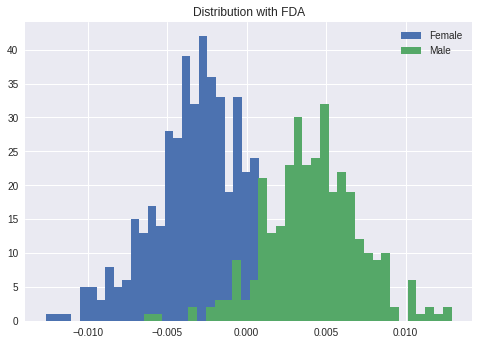

In [333]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# male is labels as 1 and female is 0
def proj_(X_train,X_test,K):
    n,p,q = X_train.shape
    n2 = X_test.shape[0]
    X = np.reshape(X_train,(n,-1))
    X_test = np.reshape(X_test,(n2,-1))
    pca = PCA(n_components=K)
    X_transformed = pca.fit_transform(X)
    proj_Xtest = pca.transform(X_test)
    #pca.fit(X)
    #X_transformed = X.dot(np.reshape(pca.components_,(p*q,K)))
    #proj_Xtest = X_test.dot(np.reshape(pca.components_,(p*q,K)))  # 200*128*128 * 128*128*50 = 200*50
    return (X_transformed,proj_Xtest)
  
proj_X,proj_Xtest = proj_(X_train,X_test,50)  

X1 = proj_X[y_train==1]
X0 = proj_X[y_train==0]
def get_mean(X):
    n,q = X.shape
    m = np.mean(X, axis=0)
    return m
m1 = get_mean(X1)

m0 = get_mean(X0)
m1.shape
def whin_scatter(X,m):
    n,p = X.shape
    tmp = np.reshape(np.zeros(p*p),(p,p))
    for i in range(n):
        X_center = np.reshape((X[i]-m),(p,1))
        tmp += X_center.dot(X_center.T) # 50*50
    return tmp
S1 = whin_scatter(X1,m1)
S1.shape
S0 = whin_scatter(X0,m0)
# Fisher face
W = np.reshape(inv(S1+S0).dot(m1-m0),(50,1))
y_pred1 = np.reshape((W.T).dot(proj_Xtest.T),200) #1*200
b = np.reshape(((W.T).dot(np.reshape(m1,(50,1)))+(W.T).dot(np.reshape(m0,(50,1)))),1)/2
print(b)
y_pred[y_pred1>b] = 1
y_pred[y_pred1<b] = 0
print(accuracy_score(y_test, y_pred))
# plot 
proj_m_app_train_50 = (W.T).dot(X1.T)
proj_f_app_train_50 = (W.T).dot(X0.T)
plt.hist(proj_f_app_train_50[0], bins = 35, label = 'Female')
plt.hist(proj_m_app_train_50[0], bins = 35, label = 'Male')
plt.legend()
plt.title('Distribution with FDA')
plt.show

## (2) Compute the Fisher face for the key point (geometric shape) and Fisher face for the appearance (after aligning them to the mean position) respectively. Project all the faces to the 2D-feature space learned by the fisher-faces, and visualize how separable these points are.

In [0]:
X = np.load("/content/drive/My Drive/Colab Notebooks/image_labels.npy")
y = np.array(list(np.ones(412)) + list(np.zeros(588)))
X_appear = np.reshape(X[:,:,:,2],(1000,128,128,1))
X_mat = np.load("/content/drive/My Drive/Colab Notebooks/landmarks_labels (1).npy")

### Get the aligned appearance to the mean position (Using 2.1.3 part)





In [0]:
!pip install imageio
# For training set
# first align the images by warping their landmarks into the mean position
#np.load("/content/drive/My Drive/Colab Notebooks/mywarper.py")
from mywarper import warp


img_train, img_test, m_train, m_test,y_train,y_test = train_test_split(X_appear,X_mat,y,test_size=0.2,random_state = 123)

def get_ali(img_train, img_test, m_train, m_test):
    n,p1 = img_train.shape[0:2]
    n,p2,q2 = m_train.shape[0:3]
    n2 = img_test.shape[0]
    np.reshape(m_train,(n,-1))

    tc = np.mean(np.reshape(m_train,(n,-1)),axis = 0)
    ali_img = []
    for i in range(n):
        a = warp(img_train[i],m_train[i],np.reshape(tc,(p2,q2)))
        #print(a)
        ali_img.append(a)
    ali_train = np.array(ali_img)


    # For testing part

    #ii) Warp the face image to the mean position and then project to the top k (say K=50) eigen-faces, 
    #you get the reconstructed image at mean position (here you further lose a bit of appearance accuracy).
    # recons_testali.shape 200*128*128

    train_mean = np.reshape(np.mean(np.reshape(m_train,(n,-1)),axis = 0),(p2,q2))
    img_train_mean = np.mean(np.reshape(img_train,(n,-1)),axis = 0)
    test_ali = []
    for i in range(n2):
        a = warp(img_test[i],m_test[i],train_mean)
        test_ali.append(a)
    ali_test = np.array(test_ali)

    return(ali_train,ali_test)

ali_train,ali_test = get_ali(img_train, img_test, m_train, m_test)
ali_test.shape

### Compute the Fisher Face W for both appearance and landmark

In [376]:
# male is labels as 1 and female is 0
def proj_(X_train,X_test,K):
    n,p,q = X_train.shape[0:3]
    n2 = X_test.shape[0]
    X = np.reshape(X_train,(n,-1))
    X_test = np.reshape(X_test,(n2,-1))
    pca = PCA(n_components=K)
    X_transformed = pca.fit_transform(X)
    proj_Xtest = pca.transform(X_test)  # 200*128*128 * 128*128*50 = 200*50
    return (X_transformed,proj_Xtest)
def get_mean(X):
    n,q = X.shape
    m = np.mean(X, axis=0)
    return m
def whin_scatter(X,m):
    n,p = X.shape
    tmp = np.reshape(np.zeros(p*p),(p,p))
    for i in range(n):
        X_center = np.reshape((X[i]-m),(p,1))
        tmp += X_center.dot(X_center.T) # 50*50
    return tmp
  
def FisherFace(X_train,X_test,K):
    proj_X,proj_Xtest = proj_(X_train,X_test,K)  

    X1 = proj_X[y_train==1]
    X0 = proj_X[y_train==0]

    m1 = get_mean(X1)

    m0 = get_mean(X0)
    m1.shape

    S1 = whin_scatter(X1,m1)
    S1.shape
    S0 = whin_scatter(X0,m0)
    # Fisher face
    W = np.reshape(inv(S1+S0).dot(m1-m0),(K,1))
    return (W,proj_Xtest)
W_appear,proj_test_appear = FisherFace(ali_train,ali_test,50)

W_geo,proj_test_landmark = FisherFace(m_train, m_test,10)

(200, 50)

### project all the faces to the 2D-feature space

It can tell apart male and female

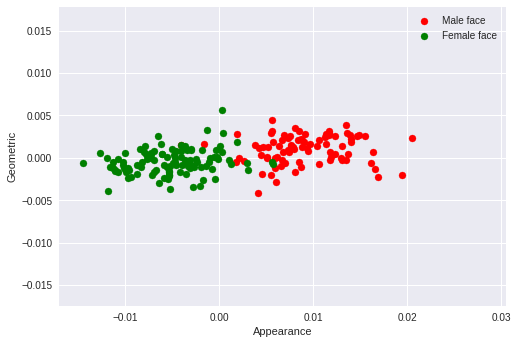

In [384]:
x1 = np.reshape((W_appear.T).dot(proj_test_appear.T),200)
x1_male = x1[y_test==1]
x1_female = x1[y_test==0]
x2 = np.reshape((W_geo.T).dot(proj_test_landmark.T),200)
x2_male = x2[y_test==1]
x2_female = x2[y_test==0]
# plot 
import matplotlib.pyplot as plt
plt.scatter(x1_male, x2_male, color='r',label='Male face')
plt.scatter(x1_female, x2_female, color='g',label='Female face')
plt.xlabel('Appearance')
plt.ylabel('Geometric')
plt.legend()
plt.show()